In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits import mplot3d

%matplotlib inline

In [0]:
class OrbitSim(object):

    def __init__(self,func,r0,v0,T=4*np.pi,tau=1e-1):
        self.func   = func
        self.r0     = np.array(r0)
        self.v0     = np.array(v0)
        self.T      = T
        self.tau    = tau

        self.t = np.arange(0,T,tau)
        self.steps = len(self.t)
        self.x = np.zeros((self.steps,len(r0)+len(v0)))
        self.x[0,:] = [*r0,*v0]

    def integrate(self):
        """ Use RK4 to solve """
        for i in range(self.steps-1):
            f1 = self.func(self.x[i,:],self.t[i])
            f2 = self.func(self.x[i,:]+self.tau*f1/2,self.t[i]+self.tau/2)
            f3 = self.func(self.x[i,:]+self.tau*f2/2,self.t[i]+self.tau/2)
            f4 = self.func(self.x[i,:]+self.tau*f3,self.t[i]+self.tau)
            self.x[i+1,:] = self.x[i,:] + self.tau*(f1 + 2*f2 + 2*f3 + f4)/6

        return self

    def plot_orbit(self,figsize=(8,6),delay = 0):

        if delay <= 0:
            if len(self.r0) == 2: # 2D geometry
                fig,ax = plt.subplots(figsize=figsize)
                plt.xlabel('x'); plt.ylabel('y')
                ax.plot(self.x[:,0],self.x[:,1],'-')
                ax.plot(self.x[-1,0],self.x[-1,1],'o')
                ax.plot(self.x[0,0],self.x[0,1],'*')
            elif len(self.r0) == 3: # 3D geometry
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111, projection='3d')
                plt.xlabel('x'); plt.ylabel('y');# plt.zlabel('z')
                ax.plot(self.x[:,0],self.x[:,1],self.x[:,2],'-')
                #ax.plot(self.x[-1,0],self.x[-1,1],self.x[-1,2],'o')
                #ax.plot(self.x[0,0],self.x[0,1],self.x[-1,2],'*')
            
        else:
            """ Warning: animations don't seem to work in jupyter notebooks """
            l, = ax.plot([],[])
            def animate(i):
                l.set_data(self.x[:i,0], self.x[:i,1])

            ani = matplotlib.animation.FuncAnimation(fig, animate, frames=self.steps,interval=30, blit=True)

            from IPython.display import HTML
            HTML(ani.to_jshtml())
            
    def plot_quants(self,pot_func):
        """ plots the angular momentum and energy over time. requires the function of the potential """
        L = np.zeros((self.steps,))
        E = np.zeros((self.steps,))

        for i in range(self.steps):
            if len(self.r0) == 3: L[i] = np.linalg.norm( np.cross(self.x[i,:len(self.r0)],self.x[i,len(self.r0):]) )
            else: L[i] = np.linalg.norm( np.cross( [*self.x[i,:len(self.r0)],0],[*self.x[i,len(self.r0):],0]) )

            x1 = self.x[i,0]; 
            E[i] = 0.5*np.linalg.norm(self.x[i,len(self.r0):])**2 + pot_func(self.x[i,:len(self.r0)])
        
        plt.plot(np.arange(self.steps),L,label='angular momentum')
        plt.plot(np.arange(self.steps),E,label='energy')
        plt.legend()
        plt.xlabel('time steps')
    
    def light_profile(self,dx=0.01,dy=0.01):
        """ bin and show the light profile """
        self.dx = dx
        self.dy = dy

        # generate 2 2d grids for the x & y bounds
        y, x = np.mgrid[slice(min(self.x[:,1]), max(self.x[:,1]) + dy, dy),
                        slice(min(self.x[:,0]), max(self.x[:,0]) + dx, dx)]
        ybins = (max(self.x[:,1]) -min(self.x[:,1]) )//dy
        xbins = (max(self.x[:,0]) -min(self.x[:,0]) )//dx


        H, yedges, xedges = np.histogram2d(self.x[:,1],self.x[:,0],bins=(xbins,ybins))

        fig, ax = plt.subplots()
        ax.contourf(H,cmap='gray')
        plt.xlabel('x')
        plt.ylabel('y')
        #plt.axis('equal')
        plt.axis('off')


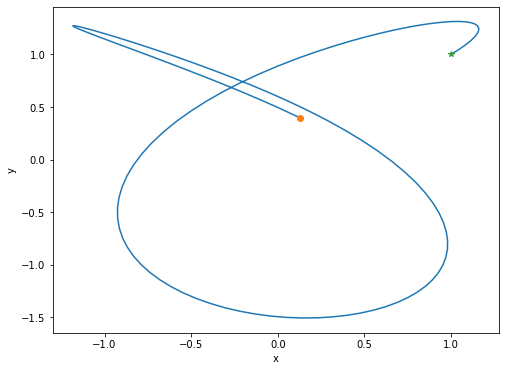

In [3]:
def case1(x0,t):
    assert len(x0) == 4 # 2D geometry

    x = x0[0]
    y = x0[1]
    vx = x0[2]
    vy = x0[3]

    rhs = np.zeros((len(x0),))
    rhs[0:2] = x0[2:]
    rhs[2] = -1/(1+x**2+y**2/2)*2*x
    rhs[3] = -1/(1+x**2+y**2/2)*y

    return rhs

def potential1(x0):
    x = x0[0]
    y = x0[1]

    return np.log(1+x**2+y**2/2)

task1 = OrbitSim(case1,r0=[1,1],v0=[0.5,0.5],T=4*np.pi,tau=1e-1)
task1.integrate().plot_orbit()

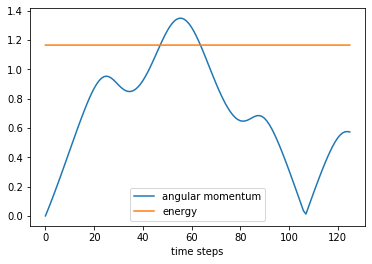

In [4]:
task1.plot_quants(pot_func=potential1)

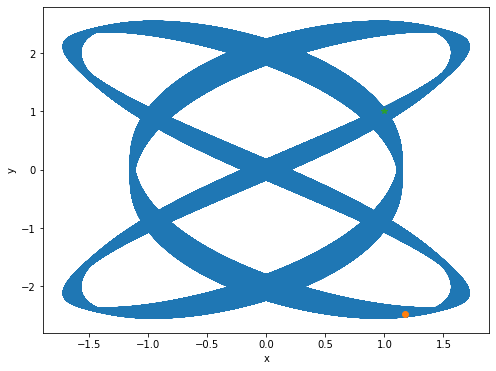

In [5]:
task2 = OrbitSim(case1,r0=[1,1],v0=[1,1],T=4e3*np.pi,tau=1e-1)
task2.integrate().plot_orbit()

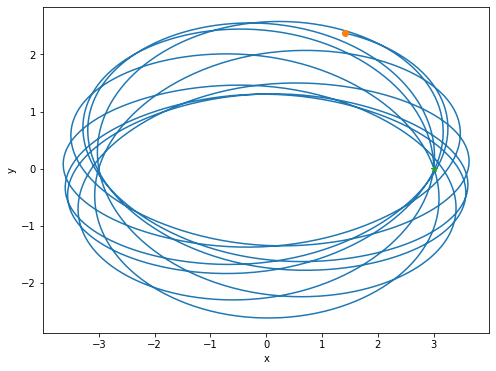

In [6]:
task3 = OrbitSim(case1,r0=[3,0],v0=[0,1],T=4e1*np.pi,tau=1e-1)
task3.integrate().plot_orbit()

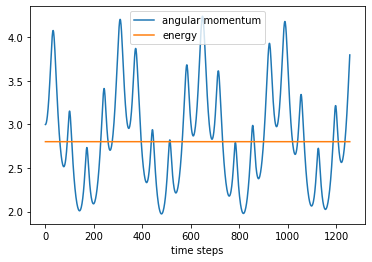

In [7]:
task3.plot_quants(pot_func=potential1)

(-4.099475422473678, 4.094017435419171, -2.899918292041559, 2.9386274764439118)

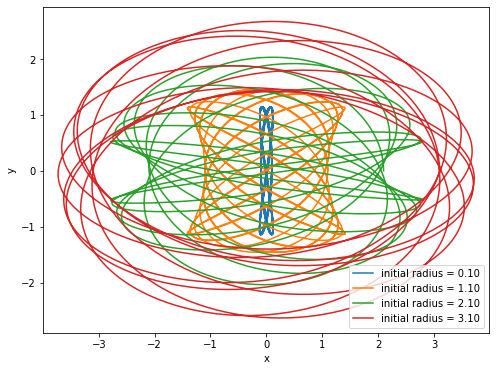

In [8]:
fig,ax = plt.subplots(figsize=(8,6))
for r in np.arange(0.1,4):
    task = OrbitSim(case1,r0=[r,0],v0=[0,1],T=4e1*np.pi,tau=1e-1).integrate()
    ax.plot(task.x[:,0],task.x[:,1],label=f'initial radius = {r:.2f}')
    plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best')
plt.axis('equal')

(-1.9163760282992983,
 1.9081860548043843,
 -3.278478401086334,
 3.2828072868263707)

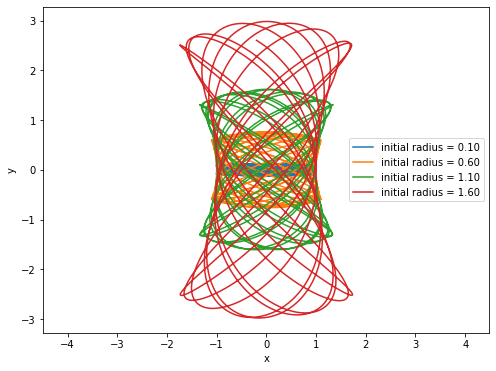

In [9]:
fig,ax = plt.subplots(figsize=(8,6))
for v in np.arange(0.1,2,0.5):
    task = OrbitSim(case1,r0=[1,0],v0=[0,v],T=4e1*np.pi,tau=1e-1).integrate()
    ax.plot(task.x[:,0],task.x[:,1],label=f'initial radius = {v:.2f}')
    plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best')
plt.axis('equal')

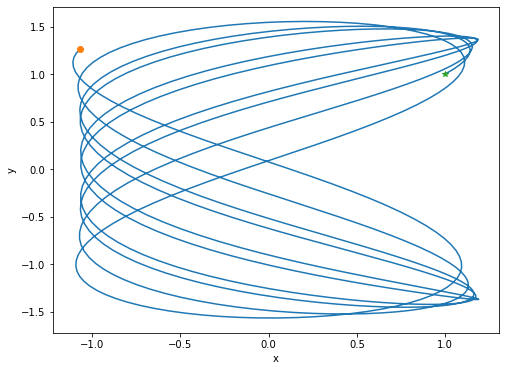

In [10]:
def case2(x0,t):
    assert len(x0) == 4 # 2D geometry

    x = x0[0]
    y = x0[1]
    vx = x0[2]
    vy = x0[3]

    rhs = np.zeros((len(x0),))
    rhs[0:2] = x0[2:]
    rhs[2] = -1/(1+x**2+y**2/4)*2*x
    rhs[3] = -1/(1+x**2+y**2/4)*y/2

    return rhs

def potential2(x0):
    x = x0[0]
    y = x0[1]

    return np.log(1+x**2+y**2/4)

task4 = OrbitSim(case2,r0=[1,1],v0=[0.5,0.5],T=20*np.pi,tau=1e-1)
task4.integrate().plot_orbit()

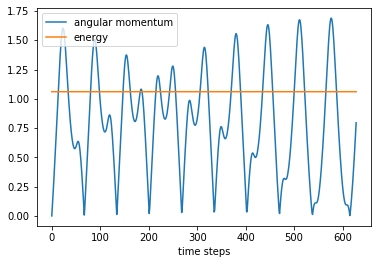

In [11]:
task4.plot_quants(pot_func=potential2)

(-0.5957378080926607,
 0.5522405443649936,
 -1.2081512941819508,
 1.2083085807343752)

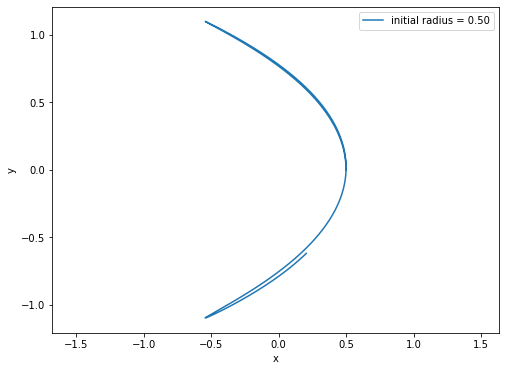

In [12]:
fig,ax = plt.subplots(figsize=(8,6))
for r in np.arange(0.5,1):
    task = OrbitSim(case2,r0=[r,0],v0=[0,0.7],T=3*np.pi,tau=1e-3).integrate()
    ax.plot(task.x[:,0],task.x[:,1],label=f'initial radius = {r:.2f}')
    plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best')
plt.axis('equal')

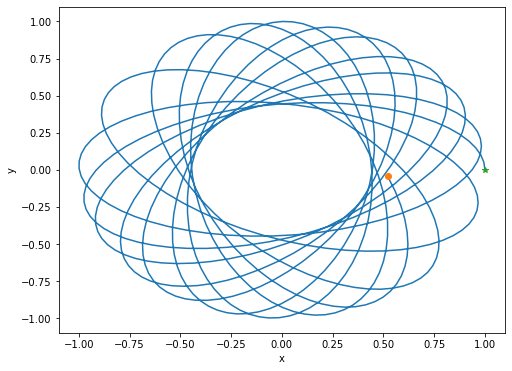

In [13]:
def case3(x0,t):
    assert len(x0) == 4 # 2D geometry

    x = x0[0]
    y = x0[1]
    vx = x0[2]
    vy = x0[3]

    rhs = np.zeros((len(x0),))
    rhs[0:2] = x0[2:]
    rhs[2] = -1/(1+x**2+y**2)*2*x
    rhs[3] = -1/(1+x**2+y**2)*2*y

    return rhs

def potential3(x0):
    x = x0[0]
    y = x0[1]

    return np.log(1+x**2+y**2)

task5 = OrbitSim(case3,r0=[1,0],v0=[0,0.5],T=20*np.pi,tau=1e-1)
task5.integrate().plot_orbit()

(-2.2886477694714658,
 2.290051051035761,
 -2.2891075808121846,
 2.291326792203596)

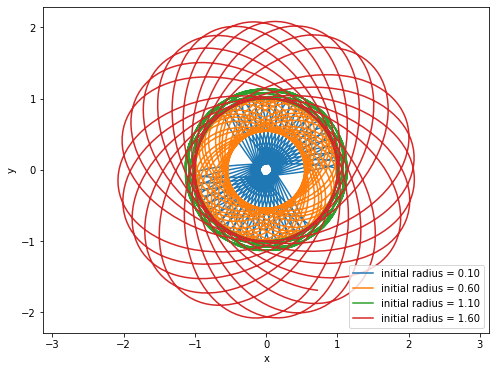

In [14]:
fig,ax = plt.subplots(figsize=(8,6))
for v in np.arange(0.1,2,0.5):
    task = OrbitSim(case3,r0=[1,0],v0=[0,v],T=4e1*np.pi,tau=1e-1).integrate()
    ax.plot(task.x[:,0],task.x[:,1],label=f'initial radius = {v:.2f}')
    plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best')
plt.axis('equal')

# 3: Calculating orbits in a 3D potential

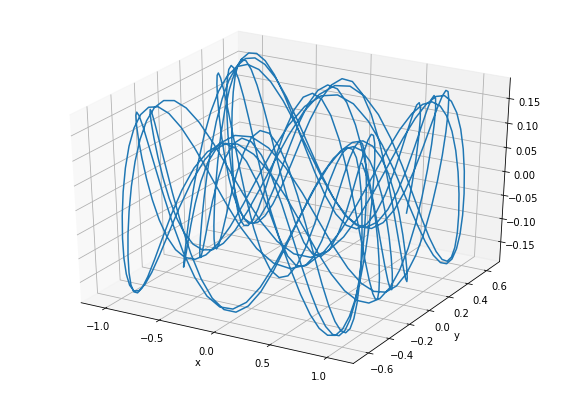

In [15]:
def case4(x0,t):
    assert len(x0) == 6 # 3D geometry

    x = x0[0]
    y = x0[1]
    z = x0[2]
    vx = x0[3]
    vy = x0[4]
    vz = x0[5]

    rhs = np.zeros((len(x0),))
    rhs[0:3] = x0[3:]
    rhs[3] = -1/(1+x**2+y**2/2+8*z**2)*2*x
    rhs[4] = -1/(1+x**2+y**2/2+8*z**2)*y
    rhs[5] = -1/(1+x**2+y**2/2+8*z**2)*16*z

    return rhs

def potential3(x0):
    x = x0[0]
    y = x0[1]
    z = x0[2]

    return np.log(1+x**2+y**2/2+8*z**2)

task6 = OrbitSim(case4,r0=[1,0,0],v0=[0,0.5,0.5],T=20*np.pi,tau=1e-1)
task6.integrate()
task6.plot_orbit(figsize=(10,7))

Text(0, 0.5, 'z')

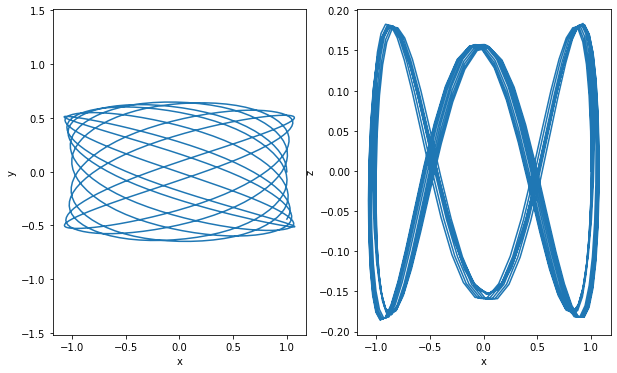

In [16]:


plt.subplots(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(task6.x[:,0],task6.x[:,1])
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(task6.x[:,0],task6.x[:,2])
plt.xlabel('x'); plt.ylabel('z')

# 4: Constructing time-integrated orbital densities

In [17]:
%time task6 = OrbitSim(case4,r0=[1,0,0],v0=[0,0.5,0.5],T=2e4*np.pi,tau=1e-1).integrate()

CPU times: user 39.2 s, sys: 6.01 ms, total: 39.2 s
Wall time: 39.3 s


In [0]:
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(min(task6.x[:,1]), max(task6.x[:,1]) + dy, dy),
                slice(min(task6.x[:,0]), max(task6.x[:,0]) + dx, dx)]
ybins = (max(task6.x[:,1]) -min(task6.x[:,1]) )//dy
xbins = (max(task6.x[:,0]) -min(task6.x[:,0]) )//dx

(0.0, 128.0, 0.0, 213.0)

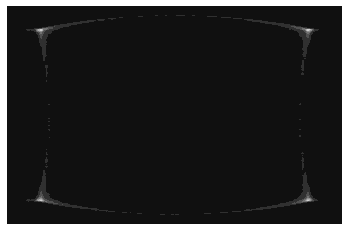

In [19]:

H, yedges, xedges = np.histogram2d(task6.x[:,1],task6.x[:,0],bins=(xbins,ybins))

fig, ax = plt.subplots()
ax.contourf(H,cmap='gray')
plt.xlabel('x')
plt.ylabel('y')
#plt.axis('equal')
plt.axis('off')

CPU times: user 54.3 s, sys: 47.4 ms, total: 54.3 s
Wall time: 54.5 s


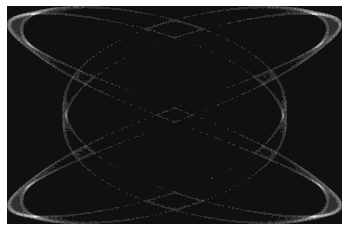

In [23]:
%time task7 = OrbitSim(case1,r0=[1,1],v0=[1,1],T=4e4*np.pi,tau=1e-1).integrate()

task7.light_profile()